## Customer Segmentation

In [ ]:
# import the desired packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.offline as pyo

**1. Load the customers.csv dataset. Apply a Z-score normalisation on the numerical features, i.e. age, income and score.**

In [ ]:
# read the csv into a dataframe and print the first 5 rows
path = "/Users/Lenovo/OneDrive - Imperial College London/Spring 2022/Machine Learning/Assignment 4"
customers_df = pd.read_csv(path + '/customers.csv')
customers_df.head()

In [ ]:
numerical_df = customers_df.iloc[:,2:] # retrieve numerical columns

# the fit method in StandardScaler compute the mean and stdv of the training sample for later use
zscore = StandardScaler() # for less repetition we define the variable zscore as StandardScaler()
zscore.fit(numerical_df) # compute mean and stdv
print('The mean of Age, Income, Score are:', zscore.mean_)
print('The stdv of Age, Income, Score are:', [round(math.sqrt(i),2) for i in zscore.var_])

# normalise the numerical coulumns
scaled_array = zscore.transform(numerical_df) # array containing standardised num data
scaled_df = pd.DataFrame(scaled_array, index = numerical_df.index, columns = numerical_df.columns) #array to dataframe
full_df = scaled_df.assign(ID = customers_df.ID, Gender = customers_df.Gender) # add rest of columns
scaled_df.head()

**2. Perform K-means with different k values, k = 2, 3, .., 10. In computing the distance, use only the normalised features from the previous point. Use a heuristic measure to find the best k.**

In [ ]:
def KMeans_alg(data):
    sum_dist_list = [] # initialise an empty list that will iteratively be appended the sum of distance to centroids
    cluster_range = [i for i in range(1,11)] # list containing values of cluster range from 1 to 10
    for cluster in cluster_range: # for loop going through all the values of cluster number at a time
        KM = KMeans(n_clusters = cluster) # initialise Kmeans for the number of cluster k
        KM.fit(data) # fit the model with the data 
        centroids = KM.cluster_centers_ # centroids coordinates
        prediction = KM.predict(data) # predict function
        sum_dist_list.append(KM.inertia_)

    %matplotlib inline
    # plot the figure
    plt.scatter(range(1,11), sum_dist_list, c = 'r')
    plt.plot(range(1,11), sum_dist_list, c = 'black')
    plt.xlabel('Number of clusters K')
    plt.ylabel('Sum of distances to cluster centroids')

KMeans_alg(scaled_df)

One efficient heuristic measure to find the optimal number of clusters K isd using the "elbow method". In fact, we plotted above the obtained sum of distances to clusters centroids from each data point against its respective number of clusters K. Obviously, as the number of clusters increase, the sum of distances will also decrease since the data will be overfitted. One way to find the optimal number of clusters where its value will neither underfit or overfit the data is using the elbow method: the line will rapidly change at one point, looking likle the "elbow" of an arm. In our case, the elbow is present at K = 4. Note that the elbow method doesn't always work well, especially if the data is not very clustered. 

#### 3. Cluster the samples using K-means with the best k. Plot the clusters and centroids (in 3D with denormalised axes). Can you find any meaningful results? Can you identify customer segments?


In [ ]:
KM = KMeans(n_clusters = 4) # initialise Kmeans for the number of cluster k
KM.fit(scaled_df) # fit the model with the data 
centroids = KM.cluster_centers_ # centroids coordinates
prediction = KM.predict(scaled_df) # predict the classes of our data

pyo.init_notebook_mode() # display the 3d graph in jupyter notebook

# we start by defining our scene and the axes
Scene = dict(xaxis = dict(title  = 'Age'),yaxis = dict(title  = 'Score'),
             zaxis = dict(title  = 'Income'))


labels = KM.labels_ # output the classes of our data points 
colors_lab = [] # empty list that will hold the color of each point depending on its class

for i in labels: # for each prediction
    if i == 0: # if data point is part of cluster 0 assign color aqua
        colors_lab.append('aqua')
    elif i == 1: # if data point is part of cluster 1 assign color lime
        colors_lab.append('lime')
    elif i == 2: # if data point is part of cluster 2 assign color yellow
        colors_lab.append('yellow')
    elif i == 3: # if data point is part of cluster 3 assign color red
        colors_lab.append('red')

# generate trace that will hold the data points and their classes (with denormalised axes)
trace = go.Scatter3d(x = customers_df.iloc[:, 2], y=customers_df.iloc[:, 4], z=customers_df.iloc[:, 3], mode='markers',
                     marker=dict(color = colors_lab, size= 10, line=dict(color= 'black',width = 10)))

# denormalise centroid coordinates 
centroids_coor = zscore.inverse_transform(centroids)
# generate trace2 that will hold the centroids of the classes in black
trace2 = go.Scatter3d(x = centroids_coor[:, 0], y=centroids_coor[:, 2], z=centroids_coor[:, 1], mode='markers',
                     marker=dict(color = 'black', size= 12, line=dict(color= 'black',width = 10)))

# define layout
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
# merge both traces in one list
data = [trace, trace2]
# plot the 3d scatter with the data defined above
fig = go.Figure(data = data, layout = layout)
fig.show()

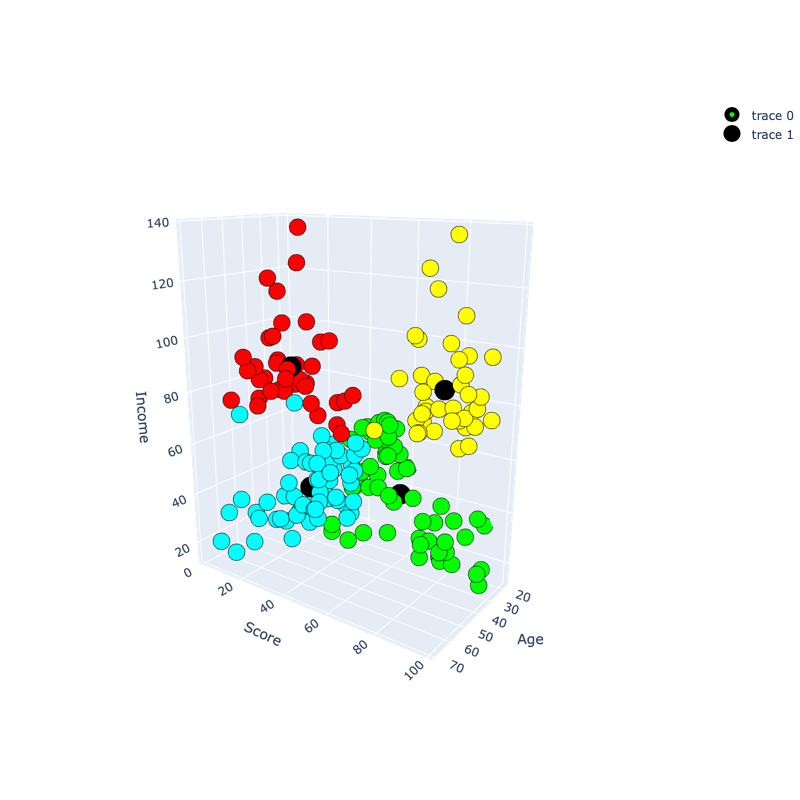

As shown in the 3D plot above (a screenshot was added in case the 3D plot does not appear in the html file), we can clearly find 4 cluster segments represented in a different colour with their centroids shown in black at the center of each cluster. The first customer segment is the red class, that defines customers of all range of age (between 20 to 70 years old) with a low credit score between 0 and 30 (that reflects how reliable a customer is when it comes to repaying money) and a high income (between 80 to 140). This means that group red represents people of all age that earn a high income but does bad at repaying money. 

The second customer segment is the yellow class, that represents mainly middle aged customers (between 30 to 40 years old) with a high credit score between 80 and 100 and a high income (between 80 to 140). This means that group yellow represents middle aged customer (between 20 and 30) that earn a high income and has a high credit score. 

The third customer segment is the green class, that represents mainly young customers (between 20 to 40 years old) with a more distributed credit score between 40 and 100 (skewed toward a high score) and a lower income (between 20 to 50). This means that group green represents younger customers that earn a low income and an average high score.


The last customer segment is the blue class, that represents old customers (between 50 to 70 years old) with a low credit score between 0 and 60 (skewed toward a low score) and a lower income (between 20 to 50). This means that group blue represents old customers that earn a low income and an average low score.

**4. Create three different datasets, each with two out of the three features you normalised, i.e. (age,income), (age, score), (income, score). Perform K-means and find the best k for each of them.**


In [ ]:
age_inc = scaled_df.iloc[:, :2] # retrieve the age and income feature only
age_score = scaled_df.iloc[:, [0,2]] # retrieve the age and score feature only
inc_score = scaled_df.iloc[:, 1:] # retrieve the score and income feature only

#### Age & Income

In [ ]:
KMeans_alg(age_inc) # call the function created above for this dataset

The best optimal model was found at K = 3, meaning that between the age and income features three groups stand out.

#### Age & Score

In [ ]:
KMeans_alg(age_score) # call the f8unction created above for this dataset

The best optimal model was found at K = 2, meaning that between the age and score features only two groups stand out.

#### Income & Score

In [ ]:
KMeans_alg(inc_score) # call the f8unction created above for this dataset

The best optimal model was found at K = 5, meaning that between the score and income features five groups stand out.

**5. Plot the clusters and distinguish the data points based on the ‘Gender’ categorical feature. (You can use the visualisation method you prefer, e.g scatter plots with different markers, bar plots, etc.) Can you recognise customer subsegments that you did not identify earlier? Is it worth converting ‘Gender’ into a binary variable and including it in the K-means?**

In [ ]:
ax = customers_df['Gender'].value_counts().plot(kind='bar',
                                     rot = 0,
                                    title="Count for each Gender", color = ['crimson','blue'])
ax.set_ylabel("Frequency")


Overall, the dataset is balanced on the Gender categorical feature with a slight higher count fo rthe female gender.

#### Age & Income

In [ ]:
KM = KMeans(n_clusters = 3) # initialise Kmeans for the number of cluster k
KM.fit(age_inc) # fit the model with the data 
centroids = KM.cluster_centers_ # centroids coordinates
prediction = KM.predict(age_inc)

labels = KM.labels_
sns.scatterplot(x="Age", 
                y="Income",
                s = 50,
                style="Gender",
                hue=labels,
                markers=['s', '^'],
                palette=['lime','yellow','aqua'],
                edgecolor = 'black',
                data=customers_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Age')
plt.ylabel('Income')

#### Age & Score

In [ ]:
KM = KMeans(n_clusters = 2) # initialise Kmeans for the number of cluster k
KM.fit(age_score) # fit the model with the data 
centroids = KM.cluster_centers_ # centroids coordinates
prediction = KM.predict(age_score)

labels = KM.labels_
sns.scatterplot(x="Age", 
                y="Score",
                s = 50,
                style="Gender",
                hue=labels,
                markers=['s', '^'],
                palette=['lime','aqua'],
                edgecolor = 'black',
                data=customers_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Age')
plt.ylabel('Income')

#### Income & Score

In [ ]:
KM = KMeans(n_clusters = 5) # initialise Kmeans for the number of cluster k
KM.fit(inc_score) # fit the model with the data 
centroids = KM.cluster_centers_ # centroids coordinates
prediction = KM.predict(inc_score)

labels = KM.labels_
sns.scatterplot(x="Income", 
                y="Score",
                s = 50,
                style="Gender",
                hue=labels,
                markers=['s', '^'],
                palette=['lime','aqua','yellow','red','magenta'],
                edgecolor = 'black',
                data=customers_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Score')
plt.ylabel('Income')

From the above plots, we can see that each segment have a balanced distribution of male and female customer, meaning that it would be insignificant to add the categorical feature as a binary variable. Moreover, it is unlikely that binary data can be clustered satisfactorily since the Euclidean distance used by K-Means becomes similar to counting the number of variables on which two group are not the same. Due to the binary state of a variable, there will be ties between the distances of centroids and data points, and the class will be assigned to a cluster in a random way. Using Euclidean distance (the only measure available to K-Means), it is impossible to overcome the symmetry and break the ties in any meaningful way.

On the other hand, the income vs score plot clearly shows the presence of 5 clusters that was not identified in the initial model where we used three numerical features. The new cluster in question is the magenta one, being customers with a middle income (between 40 to 60) and a moderately middle score between 40 and 70. The income and score features seems to be the most important features, being the most representative of the segment of customers present in the business.